In [365]:
# set parameters
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

pd.options.mode.chained_assignment = None  # default='warn'

METADATA = {'Contributor': 'T. Dunn'}
FSIZE = [5,4]
FDPI = 100

In [366]:
# define functions
def find_nearest_loc(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def find_nearest_CR(CRs, array, value):
    idx = find_nearest_loc(array, value)
    CRs = np.asarray(CRs)
    return CRs[idx]

def effective_DPR(DPR, AB):
    return DPR*np.power(1.05, AB - 6)

def effective_HP(HP, AC):
    return HP*np.power(1.05, AC - 8)

def effective_XP(eHP, eDPR):
    return 0.25*eHP*eDPR

def defensive_CR(df, HP, AC):
    n = df.shape[0]
    id = find_nearest_loc(df['HP Mean'], HP)
    CR_t = df.index[id]
    AC_t = df['AC'].loc[CR_t]
    id = int(max(0, min(n - 1, id + np.fix(0.5*(AC - AC_t)))))
    CR = df.index[id]
    return CR

def offensive_CR(df, DPR, AB):
    n = df.shape[0]
    id = find_nearest_loc(df['DPR Mean'], DPR)
    CR_t = df.index[id]
    AB_t = df['AB'].loc[CR_t]
    id = int(max(0, min(n - 1, id + np.fix(0.5*(AB - AB_t)))))
    CR = df.index[id]
    return CR
    
def rsquared(y, yf):
    y = np.asarray(y)
    yf = np.asarray(yf)
    ybar = np.mean(y)
    SStot = np.sum(np.power(np.subtract(y, ybar), 2))
    SSres = np.sum(np.power(y - yf, 2))
    return 1 - SSres/SStot

In [367]:
from scipy.interpolate import interp1d

# import data
dfD = pd.read_csv('dmg-targets-cr-and-xp.csv') # 'CR','PB','XP','AC','HP Mean','AB','DPR Mean'
dfD['eHP Mean']  = dfD.apply(lambda row: effective_HP(row['HP Mean'], row['AC']), axis=1)
dfD['eDPR Mean'] = dfD.apply(lambda row: effective_DPR(row['DPR Mean'], row['AB']), axis=1)
dfD['eXP Mean'] = dfD.apply(lambda row: effective_XP(row['eHP Mean'], row['eDPR Mean']), axis=1)
dfD.set_index('CR', inplace=True)

xp2cr  = interp1d(dfD['eXP Mean'], dfD.index, kind='cubic', fill_value=(0.0,30.0), bounds_error=False)
hp2cr  = interp1d(dfD['eHP Mean'], dfD.index, kind='cubic', fill_value=(0.0,30.0), bounds_error=False)
dpr2cr = interp1d(dfD['eDPR Mean'], dfD.index, kind='cubic', fill_value=(0.0,30.0), bounds_error=False)

df0 = pd.read_csv('monster-cr-and-xp.csv')  # 'Book','Page','Type','Category','Legendary','CR','PB','XP',
                                            # 'HP','AC','adj HP','adj AC',
                                            # 'AB','adj AB','DPR', 'adj DPR'

df0['eHP']  = df0.apply(lambda row: effective_HP(row['adj HP'], row['adj AC']), axis=1)
df0['eDPR'] = df0.apply(lambda row: effective_DPR(row['adj DPR'], row['adj AB']), axis=1)
df0['eXP']  = df0.apply(lambda row: effective_XP(row['eHP'], row['eDPR']), axis=1)
#df0['eCR']  = df0.apply(lambda row: find_nearest_CR(dfD.index, dfD['eXP Mean'], row['eXP']), axis=1)
df0['D-eCR']  = df0.apply(lambda row: float(hp2cr(row['eHP'])), axis=1)
df0['O-eCR']  = df0.apply(lambda row: float(dpr2cr(row['eDPR'])), axis=1)
df0['eCR']  = df0.apply(lambda row: float(xp2cr(row['eXP'])), axis=1)
df0['eHP Ratio'] = df0.apply(lambda row: row['eHP']/dfD.loc[row['CR'], 'eHP Mean'], axis=1)
df0['eDPR Ratio'] = df0.apply(lambda row: row['eDPR']/dfD.loc[row['CR'], 'eDPR Mean'], axis=1)
df0['eCR Delta'] = df0['eCR'] - df0['CR']
df0['eXP Ratio'] = df0['eXP'] / df0['XP']
df0['eXP Skew'] = (df0['eDPR Ratio'] - df0['eHP Ratio'])/(df0['eDPR Ratio'] + df0['eHP Ratio'])

df0['D-CR DMG'] = df0.apply(lambda row: defensive_CR(dfD, row['adj HP'], row['adj AC']), axis=1)
df0['O-CR DMG'] = df0.apply(lambda row: offensive_CR(dfD, row['adj DPR'], row['adj AB']), axis=1)
df0['C-CR DMG'] = df0.apply(lambda row: find_nearest_CR(dfD.index, dfD.index, 0.5*(row['D-CR DMG'] + row['O-CR DMG'])), axis=1)
df0['C-CR DMG Delta'] = df0['C-CR DMG'] - df0['CR']
df0['XP DMG'] = df0.apply(lambda row: dfD.loc[row['C-CR DMG'], 'XP'], axis=1)
df0['XP DMG Ratio'] = df0['XP DMG'] / df0['XP']
#df0['C-CR DMG'] = 0.5*(df0['D-CR DMG'] + df0['O-CR DMG'])

len(df0.index.tolist())

1393

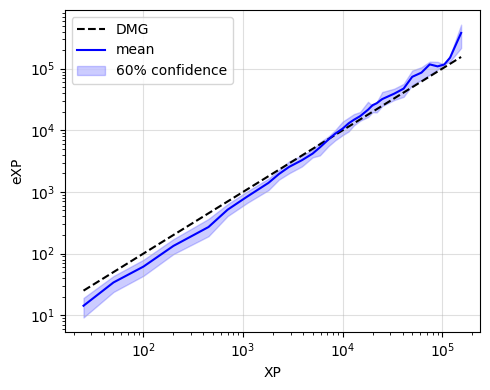

In [368]:
# calculated XP vs target XP
xCol = 'XP'
yCol = 'eXP'

conf = 0.6
df1 = df0[df0['CR'].between(0,30)]
dfG = df1.groupby(xCol).mean().reset_index()
dfU = df1.groupby(xCol).quantile(0.5 + conf/2).reset_index()
dfL = df1.groupby(xCol).quantile(0.5 - conf/2).reset_index()

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(xlabel=xCol, ylabel=yCol)
ax.set(xscale='log', yscale='log')

ax.plot(dfG[xCol], dfG[xCol], '--', color='k', label='DMG')
ax.plot(dfG[xCol], dfG[yCol], '-', color='b', label='mean')
ax.fill_between(dfG[xCol], dfL[yCol], dfU[yCol], alpha=0.2, color='b', label='{:.0f}% confidence'.format(conf*100))

ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

plt.savefig('calc-xp-vs-xp-log-log.svg', metadata=METADATA)

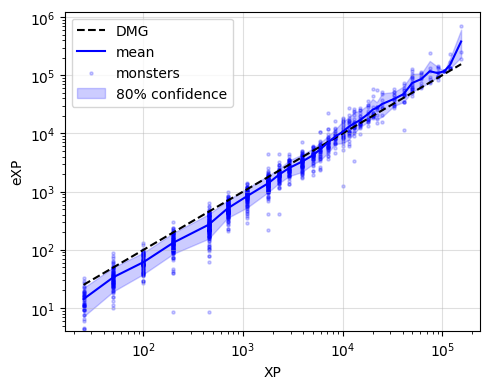

In [369]:
# XP


xCol = 'XP'
yCol = 'eXP'

conf = 0.8
df1 = df0[df0['CR'].between(0,30)]
dfG = df1.groupby(xCol).mean().reset_index()
dfU = df1.groupby(xCol).quantile(0.5 + conf/2).reset_index()
dfL = df1.groupby(xCol).quantile(0.5 - conf/2).reset_index()

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(xlabel=xCol, ylabel=yCol)
ax.set(xscale='log', yscale='log')
ax.plot(dfG[xCol], dfG[xCol], '--', color='k', label='DMG')

ax.scatter(xCol, yCol, data=df1, alpha=0.2, color='b', s=5, label='monsters')
ax.plot(dfG[xCol], dfG[yCol], '-', color='b', label='mean')
ax.fill_between(dfG[xCol], dfL[yCol], dfU[yCol], alpha=0.2, color='b', label='{:.0f}% confidence'.format(conf*100))

ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

#plt.savefig('calc-xp-vs-xp-log-log.svg', metadata=METADATA)

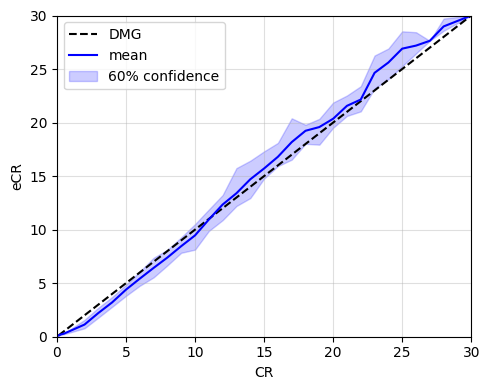

In [370]:
# calculated CR vs listed CR
xCol = 'CR'
yCol = 'eCR'

conf = 0.6
df1 = df0[df0['CR'].between(0,30)]
dfG = df1.groupby(xCol).mean().reset_index()
dfU = df1.groupby(xCol).quantile(0.5 + conf/2).reset_index()
dfL = df1.groupby(xCol).quantile(0.5 - conf/2).reset_index()

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(xlim=[0, 30], ylim=[0, 30], xlabel='CR', ylabel=yCol)

ax.plot(dfG[xCol], dfG[xCol], '--', color='k', label='DMG')
ax.plot(dfG[xCol], dfG[yCol], '-', color='b', label='mean')
ax.fill_between(dfG[xCol], dfL[yCol], dfU[yCol], alpha=0.2, color='b', label='{:.0f}% confidence'.format(conf*100))

ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

plt.savefig('xp-cr-vs-cr.svg', metadata=METADATA)

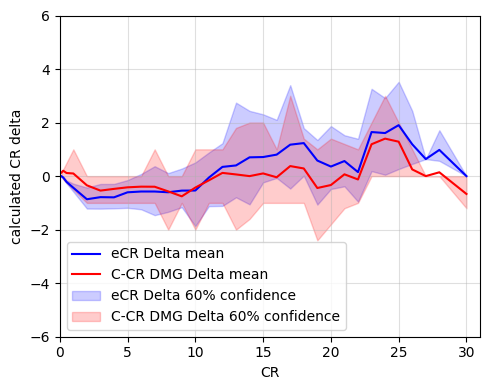

In [372]:
# DMG CR deltas
xCol = 'CR'
yCols = ['eCR Delta','C-CR DMG Delta']
colors = ['b','r']
ylabel = 'calculated CR delta'

conf = 0.6
df1 = df0[df0[xCol].between(0,30) & df0['Category'].isin(['generic','legendary','unique'])]
dfG = df1.groupby(xCol).mean().reset_index()
dfU = df1.groupby(xCol).quantile(0.5 + conf/2).reset_index()
dfL = df1.groupby(xCol).quantile(0.5 - conf/2).reset_index()

fig = plt.figure(figsize=FSIZE, dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], ylim=[-6,6], xlabel=xCol, ylabel=ylabel)

for yCol, color in zip(yCols, colors):
    ax.plot(dfG[xCol], dfG[yCol], '-', color=color, label='{} mean'.format(yCol))
    ax.fill_between(dfG[xCol], dfL[yCol], dfU[yCol], alpha=0.2, color=color, label='{} {:.0f}% confidence'.format(yCol, conf*100))

ax.legend(loc='lower left')
ax.grid(which='major', axis='both', alpha=0.4)

plt.savefig('ecr-dmg-cr-delta-vs-cr.svg', metadata=METADATA)

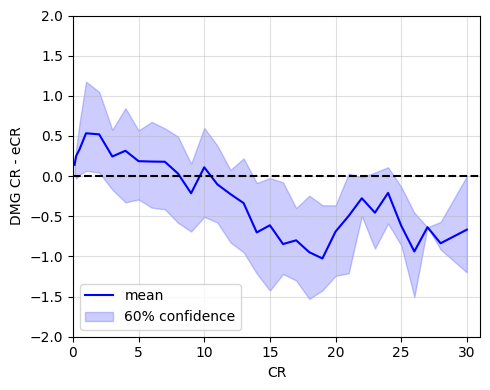

In [374]:
# DMG CR deltas
xCol = 'CR'
yCol = 'DMG CR - eCR'

conf = 0.6
df1 = df0[df0[xCol].between(0,30) & df0['Category'].isin(['generic','legendary','unique'])]
df1[yCol] = df1['C-CR DMG'] - df1['eCR']
dfG = df1.groupby(xCol).mean().reset_index()
dfU = df1.groupby(xCol).quantile(0.5 + conf/2).reset_index()
dfL = df1.groupby(xCol).quantile(0.5 - conf/2).reset_index()

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(xlim=[0, 31], ylim=[-2,2], xlabel=xCol, ylabel=yCol)

ax.plot(dfG[xCol], dfG[yCol], '-', color='b', label='mean')
ax.fill_between(dfG[xCol], dfL[yCol], dfU[yCol], alpha=0.2, color='b', label='{:.0f}% confidence'.format(conf*100))
ax.plot([0, 31], [0,0], '--', color='k', label='')

ax.legend(loc='lower left')
ax.grid(which='major', axis='both', alpha=0.4)

plt.savefig('dmg-cr-delta-vs-cr.svg', metadata=METADATA)

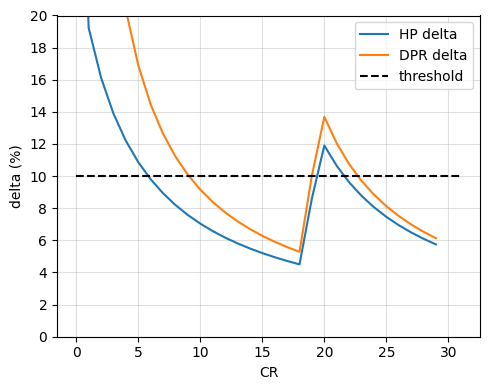

In [375]:
x_array = dfD.index.to_numpy()
x_array = x_array[0:-1]

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(ylim=[0, 20], xlabel='CR', ylabel='delta (%)')

y_array = dfD['HP Mean'].to_numpy()
y_array = np.subtract(np.divide(y_array[1:], y_array[0:-1]), 1)
ax.plot(x_array, 100*y_array, label='HP delta')

y_array = dfD['DPR Mean'].to_numpy()
y_array = np.subtract(np.divide(y_array[1:], y_array[0:-1]), 1)
ax.plot(x_array, 100*y_array, label='DPR delta')
ax.plot([0, 31], [10, 10], '--', color='k', label='threshold')

ax.legend()
ax.grid(which='major', axis='both', alpha=0.4)

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))

plt.savefig('hp-dpr-ratio-vs-cr.svg', metadata=METADATA)

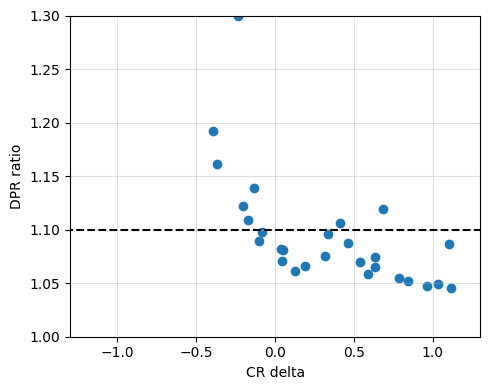

In [377]:
# DMG CR deltas
from matplotlib import pyplot as plt

df1 = df0[df0['CR'].between(0,29) & df0['Category'].isin(['generic','legendary','unique'])]
df1['eCR C-CR Delta'] = df1['eCR'] - df1['C-CR DMG']
dfG = df1.groupby('CR').median()

xp_array = dfG.index.to_numpy()
xp_array = xp_array[0:-1]

yp_array = dfG['eCR C-CR Delta'].to_numpy()
yp_array = yp_array[0:-1]


dfD1 = dfD
x_array = dfD1.index.to_numpy()
x_array = x_array[0:-1]

y_array = dfD1['HP Mean'].to_numpy()
y_array = np.divide(y_array[1:], y_array[0:-1])

mask = [(x in xp_array) for x in x_array]
x_array = x_array[mask]
y_array = y_array[mask]

fig = plt.figure(figsize=FSIZE, dpi=100, tight_layout=True)
ax = plt.axes(xlim=[-1.3,1.3], ylim=[1,1.3], xlabel='CR delta', ylabel='DPR ratio')
ax.scatter(yp_array, y_array)
ax.plot([-2, 2], [1.10, 1.10], '--', color='k', label='threshold')

ax.grid(which='major', axis='both', alpha=0.4)

#plt.savefig('dmg-cr-delta-vs-cr.svg', metadata=METADATA)

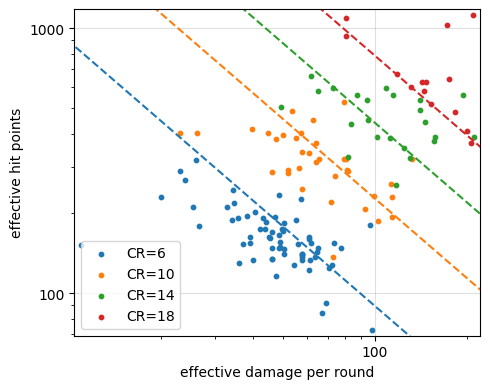

In [380]:
# eDPR vs eHP
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

CRs = [6,10,14,18]
cats = ['generic','legendary','unique']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
colors = colors[0:len(CRs)]

fig = plt.figure(figsize=FSIZE, dpi=100, tight_layout=True)
ax = plt.axes()


for CR, c in zip(CRs, colors):
    df1 = df0[df0['CR'].isin([CR]) & df0['Category'].isin(cats)]
    ax.scatter(df1['eDPR'], df1['eHP'], label='CR='+str(CR), color=c, alpha=1.0, s=10)

#ax.legend()
ax.grid(which='major', axis='both', alpha=0.4)

mask = df0['CR'].isin(CRs) & df0['Category'].isin(cats)
xMin = np.min(df0.loc[mask, 'eDPR'])
xMax = np.max(df0.loc[mask, 'eDPR'])
yMin = np.min(df0.loc[mask, 'eHP'])
yMax = np.max(df0.loc[mask, 'eHP'])

#ax.set(xlim=[0,xMax], xlabel='effective damage per round', ylim=[0,yMax], ylabel='effective hit points')
ax.set(xlim=[0.95*xMin,1.05*xMax], xlabel='effective damage per round', xscale='log', 
       ylim=[0.95*yMin,1.05*yMax], ylabel='effective hit points', yscale='log')

ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.legend()

x = np.linspace(0.9*xMin, 1.1*xMax, 50, endpoint=True)
XP = dfD['XP'].values
for CR, c in zip(CRs, colors):
    ax.plot(x, 4*dfD.loc[CR]['eXP Mean']/x, '--', color=c)

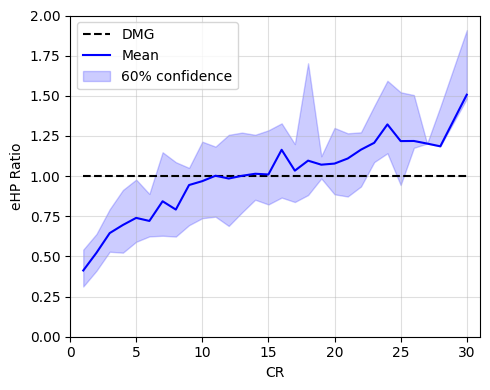

In [383]:
# eHP Ratio
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

conf = 0.6
df1 = df0[df0['CR'].between(1,30)]
dfG = df1.groupby('CR').median()
dfU = df1.groupby('CR').quantile(0.5 + conf/2)
dfL = df1.groupby('CR').quantile(0.5 - conf/2)

# CR
col = 'eHP Ratio'
fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(xlim=[0, 31], ylim=[0, 2], xlabel='CR', ylabel=col)
ax.plot([1, 30], [1,1], '--', color='k', label='DMG')
ax.plot(dfG.index, dfG[col], '-', color='b', label='Mean')
ax.fill_between(dfG.index, dfL[col], dfU[col], alpha=0.2, color='b', label='60% confidence')

ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)
#plt.savefig('dmg-cr-vs-cr.svg', metadata=METADATA)

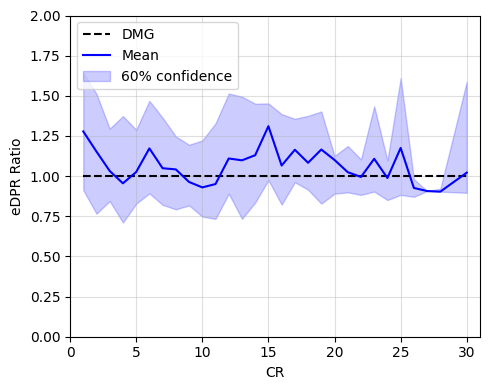

In [384]:
# eDPR Ratio
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

conf = 0.6
df1 = df0[df0['CR'].between(1,30)]
dfG = df1.groupby('CR').median()
dfU = df1.groupby('CR').quantile(0.5 + conf/2)
dfL = df1.groupby('CR').quantile(0.5 - conf/2)

# CR
col = 'eDPR Ratio'
fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(xlim=[0, 31], ylim=[0, 2], xlabel='CR', ylabel=col)
ax.plot([1, 30], [1,1], '--', color='k', label='DMG')
ax.plot(dfG.index, dfG[col], '-', color='b', label='Mean')
ax.fill_between(dfG.index, dfL[col], dfU[col], alpha=0.2, color='b', label='60% confidence')

ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)
#plt.savefig('dmg-cr-vs-cr.svg', metadata=METADATA)